# CORE Paper Figures
This Jupyter notebook generates all figures and quantiative results for the paper "CORE-Bench: Fostering the Credibility of Published Research Through a Computational Reproducibility Benchmark".

# Downloading the data

In [1]:
# import urllib.request
# import tarfile
# import os

# # URLs to download
# urls = [
#     "https://corebench.cs.princeton.edu/agent_logs.tar.gz",
#     "https://corebench.cs.princeton.edu/agent_results.tar.gz"
# ]

# # Function to download and extract .tar.gz files
# def download_and_extract(url):
#     file_name = url.split("/")[-1]
    
#     # Download the file
#     urllib.request.urlretrieve(url, file_name)
#     print(f"Downloaded {file_name}")
    
#     # Extract the file
#     with tarfile.open(file_name, "r:gz") as tar:
#         tar.extractall()
#     print(f"Extracted {file_name}")

# # Download and extract each file
# for url in urls:
#     if not os.path.exists(url.split("/")[-1]):
#         download_and_extract(url)

# Utility Functions

In [1]:
"""
Evaluates a run of the model on the benchmark.
"""
import json
import os
import numpy as np
from collections import OrderedDict, defaultdict
import seaborn as sns
from scipy.stats import t
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d
import pandas as pd

color_palette = sns.color_palette("Dark2", 10)

In [2]:
# This class contains all information about a task, compiling it from three different sources:
# the results directory, the logs directory, and the dataset directory.
# The results directory contains the report.json file, which contains the agent's submitted results of the task.
# The logs directory contains the log file, which contains the cost, time, and agent memory of the experiment.
# The dataset directory contains the dataset file, which contains the correct answers to the task.
class Task:
    def __init__(self, report_json, log_json, exp_id, cost_limit = None):
        # Get the task success directly from the result file
        self.report_json = report_json
        self.task_name = exp_id.split("_", 1)[-1]
        self.log_json = log_json

        self.capsule_id = report_json['capsule_id']
        self.field = report_json['field']
        self.language = report_json['language']
        self.llm_summary = report_json['llm_summary'] if 'llm_summary' in report_json else None
        
        self.correct_written = report_json['correct_written_answers']
        self.correct_vision = report_json['correct_vision_answers']
        self.total_written = report_json['total_written_questions']
        self.total_vision = report_json['total_vision_questions']

        self.written_success = report_json['correct_written_answers'] == report_json['total_written_questions']
        self.vision_success = report_json['correct_vision_answers'] == report_json['total_vision_questions']
        self.success = self.written_success and self.vision_success
        self.path_success = report_json['result_paths_success']
        self.any_paths = len(report_json['result_paths']) > 0

        # Load the log file to get cost and time of experiment
        if self.log_json is not None:
            self.cost = self.log_json['cost'] if 'cost' in self.log_json else None
            self.time = self.log_json['time'] if 'time' in self.log_json else None
            self.model = self.log_json['model'] if 'model' in self.log_json else None
            self.exception = self.log_json['exception'] if 'exception' in self.log_json else None
        else:
            self.cost = None
            self.time = None
            self.model = None
            self.exception = None

        # Fail the task if it exceeds the cost limit
        if cost_limit is not None and self.cost > cost_limit:
            self.success = False
            
    def __str__(self):
        return str(self.__dict__)
    
    def __repr__(self):
        return str(self.__dict__)

In [3]:
def categorize_by_level(tasks):
    categorized_tasks = OrderedDict()
    task_names = ['codeocean_easy', 'codeocean_medium', 'codeocean_hard']
    for task_name in task_names:
        categorized_tasks[task_name] = []
    for task in tasks:
        categorized_tasks[task.task_name].append(task)
    return categorized_tasks

def categorize_by_id(tasks):
    categorized_tasks = defaultdict(list)
    for task in tasks:
        categorized_tasks[task.capsule_id].append(task)
    return categorized_tasks

In [4]:
def load_tasks(*results_folders):
    tasks_from_json = []
    for results_folder in results_folders:
        tasks_from_json.extend(load_tasks_from_json(results_folder))
    return {task_level_name: categorize_by_id(task_level) for task_level_name, task_level in categorize_by_level(tasks_from_json).items()}

def load_tasks_from_json(results_folder):
    results_files = [os.path.join(results_folder, f) for f in os.listdir(results_folder)]
    tasks = []

    for results_file in results_files:
        if not results_file.endswith('.json'):
            continue
        with open(results_file, 'r') as f:
            json_file = json.load(f)
            if 'capsule_results' not in json_file:
                continue
            result_json = json_file['capsule_results']
            for task_json in result_json:
                log_file = results_file.replace('results', 'logs').replace('.json', f"/{task_json['capsule_id']}.log")
                try:
                    with open(log_file, 'r') as f:
                        log_json = json.load(f)
                except:
                    log_json = None
                tasks.append(Task(task_json, 
                                log_json, 
                                os.path.basename(results_file).replace('.json', '')))
    
    return tasks

In [5]:
def plot_success_by_level(
    tasks_by_model: list,
    legend_names: list,
    pass_at: int,
    task_names: OrderedDict = None,
    model_name: str = '',
    verbose: bool = False
):
    assert len(legend_names) == len(tasks_by_model)

    # Compute success rates by model (same logic as original)
    success_rates_by_model = [
        [
            sum(
                any(task.success for task in tasks[task_id][:pass_at])
                for task_id in tasks
            ) / len(tasks)
            for tasks in model_tasks.values()
        ]
        for model_tasks in tasks_by_model
    ]
    task_label = (
        tasks_by_model[0].keys()
        if task_names is None
        else [task_names[x] for x in tasks_by_model[0].keys()]
    )

    # Set Seaborn style
    sns.set(style='whitegrid', context='paper')

    # Define figure size and DPI
    plt.figure(figsize=(5, 3), dpi=300)

    # Convert task labels to list if they are not already
    if not isinstance(task_label, list):
        task_label = list(task_label)

    # Define bar width and positions
    n_tasks = len(task_label)
    n_models = len(tasks_by_model)
    bar_width = 0.35
    index = np.arange(n_tasks)

    # Plot success rates by model
    for i, legend_name in enumerate(legend_names):
        hatch_pattern = '//' if i == 1 else None  # Apply hatching to the second model

        plt.bar(
            index + i * bar_width,
            success_rates_by_model[i],
            width=bar_width,
            label=legend_name,
            color=color_palette[i % len(color_palette)],
            hatch=hatch_pattern  # Add hatching pattern
        )
        if verbose:
            print(f'{legend_name} Success Rate by Task Level (pass@{pass_at}):')
            for task_id, task_name in enumerate(task_label):
                print(f'\t{task_name}: {round(success_rates_by_model[i][task_id], 4)}')

    # Adjust x-axis
    plt.xlabel('Task Level', fontsize=9)
    plt.xticks(index + bar_width / 2 * (n_models - 1), task_label, fontsize=8)
    plt.ylabel('Success Rate', fontsize=9)
    plt.ylim(0, 1)
    plt.yticks(fontsize=8)

    # Add title and legend
    plt.title(f'{model_name} Success Rate by Task Level', fontsize=10)
    plt.legend(fontsize=7, frameon=True, framealpha=0.9)

    # Add grid lines
    plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7, axis='y')

    # Tight layout for better spacing
    plt.tight_layout()

    # Show the plot
    plt.show()

In [6]:
def plot_success_pass_at(
    tasks_by_model: list,
    legend_names: list,
    pass_at: int,
    task_names: dict = None,
    model_name: str = '',
    verbose: bool = False
):
    assert len(legend_names) == len(tasks_by_model)

    # Compute success rates for each pass_at
    success_rate_pass_at = []
    for k in range(1, pass_at + 1):
        success_rates_by_model = [
            [
                sum(
                    any(task.success for task in tasks[task_id][:k])
                    for task_id in tasks
                ) / len(tasks)
                for tasks in model_tasks.values()
            ]
            for model_tasks in tasks_by_model
        ]
        success_rate_pass_at.append(success_rates_by_model)

        if verbose:
            print(f'Pass@{k}: {success_rates_by_model}')
    
    # Prepare task labels
    if task_names is None:
        task_labels = list(tasks_by_model[0].keys())
    else:
        task_labels = [task_names[x] for x in tasks_by_model[0].keys()]

    # Set Seaborn style
    sns.set(style='whitegrid', context='paper')

    # Define figure size and DPI
    plt.figure(figsize=(5, 3), dpi=300)

    # Calculate total number of lines
    n_models = len(legend_names)
    n_tasks = len(task_labels)
    n_lines = n_models * n_tasks

    # Define line styles
    line_styles = ['-', '--', ':']  # Solid, dashed, and dotted

    # Plot success rates by model and task level
    line_idx = 0
    for i, legend_name in enumerate(legend_names):
        for task_id, task_name in enumerate(task_labels):
            # Extract success rates for current model and task
            success_rates = [
                success_rate_pass_at[k - 1][i][task_id] for k in range(1, pass_at + 1)
            ]
            plt.plot(
                range(1, pass_at + 1),
                success_rates,
                label=f'{legend_name} {task_name}',
                color=color_palette[line_idx % len(color_palette)],
                linestyle=line_styles[line_idx % len(line_styles)],  # Apply different line styles
                linewidth=1.5
            )
            line_idx += 1
            if verbose:
                print(f'{legend_name} {task_name} Success Rates: {success_rates}')

    # Customize plot aesthetics
    plt.xlabel('Pass@k', fontsize=9)
    plt.ylabel('Success Rate', fontsize=9)
    plt.xticks(range(1, pass_at + 1), fontsize=8)
    plt.yticks(fontsize=8)
    plt.ylim(0, 1)
    plt.title(f'{model_name} Pass@k Accuracy by Task Level', fontsize=10)
    plt.legend(fontsize=7, frameon=True, framealpha=0.9)
    plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)

    # Tight layout for better spacing
    plt.tight_layout()

    # Show the plot
    plt.show()

In [7]:
def plot_success_pass_and(
    tasks_by_model: list,
    legend_names: list,
    pass_and: int,
    task_names: dict = None,
    model_name: str = '',
    verbose: bool = False
):
    assert len(legend_names) == len(tasks_by_model)

    # Compute success rates for each pass_and
    success_rate_pass_at = []
    for k in range(1, pass_and + 1):
        success_rates_by_model = [
            [
                sum(
                    all(task.success for task in tasks[task_id][:k])
                    for task_id in tasks
                ) / len(tasks)
                for tasks in model_tasks.values()
            ]
            for model_tasks in tasks_by_model
        ]
        success_rate_pass_at.append(success_rates_by_model)

        if verbose:
            print(f'Pass@{k}: {success_rates_by_model}')
    
    # Prepare task labels
    if task_names is None:
        task_labels = list(tasks_by_model[0].keys())
    else:
        task_labels = [task_names[x] for x in tasks_by_model[0].keys()]

    # Set Seaborn style
    sns.set(style='whitegrid', context='paper')

    # Define figure size and DPI
    plt.figure(figsize=(5, 3), dpi=300)

    # Calculate total number of lines
    n_models = len(legend_names)
    n_tasks = len(task_labels)
    n_lines = n_models * n_tasks

    # Define line styles
    line_styles = ['-', '--', ':']  # Solid, dashed, and dotted

    # Plot success rates by model and task level
    line_idx = 0
    for i, legend_name in enumerate(legend_names):
        for task_id, task_name in enumerate(task_labels):
            # Extract success rates for current model and task
            success_rates = [
                success_rate_pass_at[k - 1][i][task_id] for k in range(1, pass_and + 1)
            ]
            plt.plot(
                range(1, pass_and + 1),
                success_rates,
                label=f'{legend_name} {task_name}',
                color=color_palette[line_idx % len(color_palette)],
                linestyle=line_styles[line_idx % len(line_styles)],  # Apply line styles
                linewidth=1.5
            )
            line_idx += 1
            if verbose:
                print(f'{legend_name} {task_name} Success Rates: {success_rates}')

    # Customize plot aesthetics
    plt.xlabel('Pass^k', fontsize=9)
    plt.ylabel('Success Rate', fontsize=9)
    plt.xticks(range(1, pass_and + 1), fontsize=8)
    plt.yticks(fontsize=8)
    plt.ylim(0, 1)
    plt.title(f'{model_name} Pass^k Accuracy by Task Level', fontsize=10)
    plt.legend(fontsize=7, frameon=True, framealpha=0.9)
    plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)

    # Tight layout for better spacing
    plt.tight_layout()

    # Show the plot
    plt.show()

In [8]:
def plot_accuracy_vs_cost(tasks_by_agents, agent_labels, task_name_filter, xlim_values, title):
    # Filter tasks by the specified task name
    tasks_by_agent = [
        [
            task[i]
            for tasks in tasks_by_agent.values()
            for task in tasks.values()
            for i in range(len(task))
            if task[i].task_name == task_name_filter
        ]
        for tasks_by_agent in tasks_by_agents
    ]
    
    # Calculate accuracies and costs
    accuracies = [
        sum(task.success for task in tasks) / len(tasks) if tasks else 0
        for tasks in tasks_by_agent
    ]
    costs = [
        sum(costs := [task.cost for task in tasks if task.cost is not None]) / len(costs) if tasks else 0
        for tasks in tasks_by_agent
    ]
    
    # Set the style and context
    sns.set(style='whitegrid', context='paper')
    plt.figure(figsize=(2.7, 2.8), dpi=300)
    
    # Define markers
    markers = ['s', 's', 'o', 'o']  # Keep the original marker shapes
    
    # Plotting
    for i in range(len(agent_labels)):
        plt.scatter(costs[i], accuracies[i], label=agent_labels[i],
                    marker=markers[i], s=50, color=color_palette[i], edgecolors='k', linewidth=0.5)
    
    # Add grid
    plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
    
    # Set labels and limits
    plt.xlabel('Cost (USD)', fontsize=9)
    plt.ylabel('Accuracy', fontsize=9)
    plt.xlim(xlim_values)
    plt.ylim(-0.1, 1)
    plt.xticks(fontsize=8)
    plt.yticks(fontsize=8)
    plt.title(title, fontsize=10)
    
    # Adjust legend
    plt.legend(fontsize=7, loc='best', frameon=True, framealpha=0.9)
    
    # Tight layout for better spacing
    plt.tight_layout()
    
    # Save the figure (optional)
    # plt.savefig('accuracy_vs_cost.png', dpi=300)
    
    plt.show()

In [9]:
task_name_dict = {
        'codeocean_easy': 'CORE-Bench-Easy',
        'codeocean_medium': 'CORE-Bench-Medium',
        'codeocean_hard': 'CORE-Bench-Hard'
    }

# Figures and Results

### Success rates of agents at varying cost limits

In [10]:
test_coreagent_o1_mini_tasks_cost_10 = load_tasks('results/test_coreagent_o1-mini_c-10')

In [19]:
print(test_coreagent_o1_mini_tasks_cost_10['codeocean_hard'].keys())

total_cost = 0
total_tasks = 0
for (k, v) in test_coreagent_o1_mini_tasks_cost_10['codeocean_hard'].items():
    for task in v:
        total_cost += task.cost if task.cost is not None else 0
        total_tasks += 1 if task.cost is not None else 0

print(total_cost / total_tasks)

dict_keys(['capsule-6049678', 'capsule-9052293', 'capsule-4180912', 'capsule-1900704', 'capsule-8536428', 'capsule-7186268', 'capsule-9660931', 'capsule-9054015', 'capsule-3593259', 'capsule-9137200', 'capsule-3849634', 'capsule-1624349', 'capsule-3639589', 'capsule-1175539', 'capsule-5507257', 'capsule-2708693', 'capsule-0921079', 'capsule-2345790', 'capsule-8234136', 'capsule-1394704', 'capsule-5136217', 'capsule-8807709', 'capsule-3449234', 'capsule-4728591', 'capsule-3821950', 'capsule-7716865', 'capsule-2804717', 'capsule-4252248', 'capsule-9911222', 'capsule-3262218', 'capsule-1724988', 'capsule-2816027', 'capsule-0504157', 'capsule-9240688', 'capsule-2414499', 'capsule-6003668', 'capsule-3301293', 'capsule-0851068', 'capsule-3418007', 'capsule-4671827', 'capsule-4933686', 'capsule-9670283', 'capsule-9641396', 'capsule-4299879', 'capsule-9832712'])
4.301198159090909


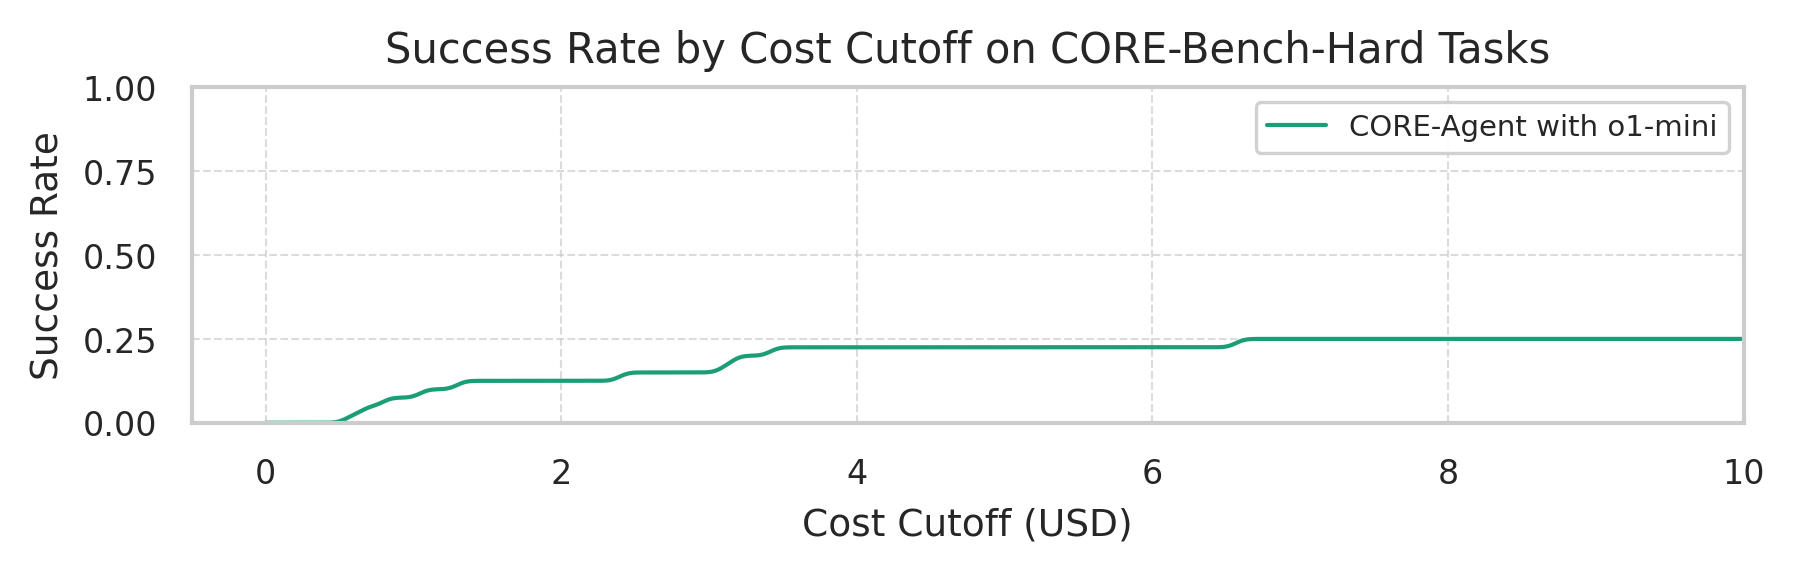

In [13]:
# Define the tasks and labels for o1-mini
tasks_by_agents = [
    [test_coreagent_o1_mini_tasks_cost_10],
]

agent_labels = [
    ['CORE-Agent with o1-mini'],
]

# Calculate success rates for each group at different cost cutoffs
cost_cutoffs = np.arange(0, 10, 0.01)
success_rates_all = []

for tasks_by_agent_group in tasks_by_agents:
    success_rates_group = []
    for tasks_by_agent in tasks_by_agent_group:
        tasks = [task[0] for tasks in tasks_by_agent.values() for task in tasks.values()]
        success_rates = [
            sum(task.success and task.cost < cost_cutoff for task in tasks) / len(tasks)
            for cost_cutoff in cost_cutoffs
        ]
        # Apply Gaussian smoothing
        smoothed_success_rates = gaussian_filter1d(success_rates, sigma=5)
        # Ensure the first point is (0, 0)
        smoothed_success_rates[0] = 0
        success_rates_group.append(smoothed_success_rates)
    success_rates_all.append(np.array(success_rates_group).T)

# Set the style and context
sns.set(style='whitegrid', context='paper')

# Create the plot
plt.figure(figsize=(6, 2), dpi=300)

# Plotting without markers
for i in range(len(agent_labels[0])):
    plt.plot(
        cost_cutoffs,
        success_rates_all[0][:, i],
        label=agent_labels[0][i],
        color=color_palette[i],
        linewidth=1.0,
        linestyle='--' if i == 1 else '-',  # Dashed for the second line (index 1)
    )

# Set labels and limits
plt.xlabel('Cost Cutoff (USD)', fontsize=9)
plt.ylabel('Success Rate', fontsize=9)

# Adjust x-axis limits to start slightly before zero
plt.xlim(-0.5, 10)  # Start x-axis at -0.5 to create an offset

# Set x-axis ticks starting from zero
plt.xticks(np.arange(0, 11, 2), fontsize=8)

plt.ylim(0, 1)
plt.yticks(fontsize=8)
plt.title('Success Rate by Cost Cutoff on CORE-Bench-Hard Tasks', fontsize=10)

# Add grid
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)

# Adjust legend
plt.legend(fontsize=7, loc='best', frameon=True, framealpha=0.9)

# Tight layout for better spacing
plt.tight_layout()

# Show the plot
plt.show()